# ISS Projekt 2023/24

Honza Pavlus, Honza Brukner a Honza Černocký, ÚPGM FIT VUT

6.11. 2023



## 1. Úvod

V projektu budete pracovat se biomedicínskými signály a to konkrétně se signálem elektrokardiogramu EKG. Vyzkoušíte si filtraci tohoto druhu signálu, abyste dostali krásné EKG křivky, které můžete vidět ve filmech. Dále si zkusíte vybudovat jednoduchý, ale účinný detektor QRS a ti, kteří se vrhnou i na bonusový úkol, si zkusí odhalit srdeční patologii. K dispozici dostanete každý 3 nahrávky jednokanálového EKG signálu, jeden zdravý a dva s různými patologiemi.

Projekt je nejlépe možno řešit v Python-u a to přímo v dodaném Python notebooku, který si můžete zkopírovat do vlastního Google Colabu. Projekt je také možno řešit v Matlab-u, Octave, Julii, jazyce C, Java nebo v libovolném jiném programovacím či skriptovacím jazyce. Je možné použít libovolné knihovny. Projekt se nezaměřuje na “krásu programování”, není tedy nutné mít vše úhledně zabalené do okomentovaných funkcí (samozřejmě se ale okomentovaný kód lépe opravuje a to hlavně v případě podivných výsledků), ošetřené všechny chybové stavy, atd. Důležitý je výsledek.

**Vaši práci odevzdáváte vyexportovanou do dvou souborů: (1) do PDF souboru login.pdf, (2) do Python notebooku login.ipynb. PDF musí obsahovat výsledky prokazatelně vytvořené Vaším kódem.** V případě řešení projektu v jiném jazyce nebo prostředí než v dodaném Python notebooku, je prvním souborem protokol v PDF, druhý soubor je archiv s Vaším kódem. Ten musí být spustitelný na standardní fakultní distribuci Windows nebo Linuxu.

## 2. Teorie - před odevzdáním prosíme smazat včetně ilustračních obrázků.

Pokud znáte základní teorii okolo EKG signálů, můžete tuhle část přeskočit. Teorie je doopravdy stručná, neboť teorie EKG není cílem tohoto předmětu.

EKG signál má několik základních částí:
  

1.   P vlnu, která značí počátek kontrakce předsíní
2.   QRS komplex vln, který vzniká depolarizací komor (jejich stažením)
3.   T vlna jako poslední představuje repolarizaci komor (tedy jejich zpětné roztažení)

Nás bude zajímat především QRS komplex, který se ve spektru nachází mezi 10 Hz a 20 Hz. Z polohy QRS lze určit RR interval - vzdálenost mezi jednotlivými R vlnami. RR interval je přímo spojený se srdečním tepem. Na obrázku spektra EKG signálu můžete také vidět, na kterých frekvencích se nachází P a T vlna, kterou my ale v projektu odfiltrujeme.

EKG se snímá v několika základních rozloženích elektrodových svodů. V nemocnici se potkáte nejčastěji s 12 svodovým EKG. V projektu dostanete jeden z těchto svodů.


#### Popis EKG





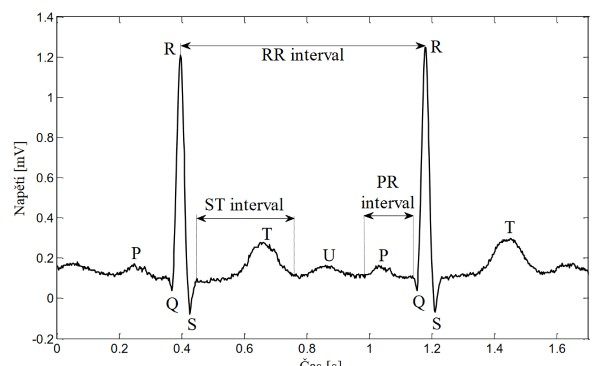

#### EKG ve spektru

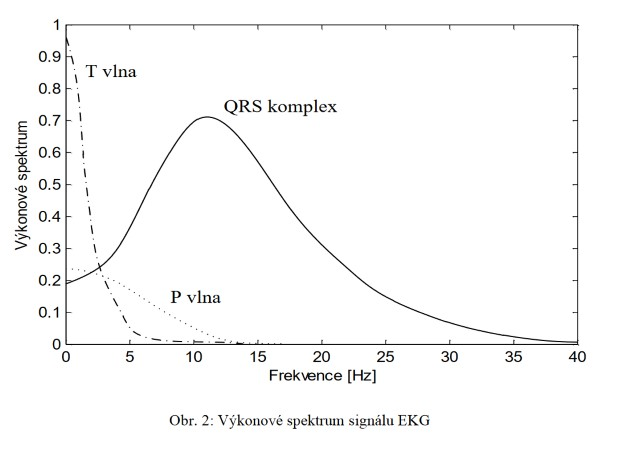

## 3. Vstup
Pro řešení projektu má každý student/ka k disposici osobní soubor se  zdravým signálem (sinusovým rytmem): ***login.wav***, kde login je váš xlogin popřípadě VUT číslo (pro studenty FSI). Dále jsou k disposici  ještě další dva signály: ***FIS.wav*** a ***KES.wav***. První signál obsahuje fibrilaci a druhý komorovou extrasystolu. Tyhle dva soubory jsou pro všechny společné a využijete je při řešení bonusového úkolu.

In [162]:
#Načtení Vašeho signálu - xlogin99 nahraďte Vaším loginem
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy.signal import butter, sosfreqz, sosfilt, resample

#!wget https://www.fit.vutbr.cz/study/courses/ISS/public/proj2023-24/FIB.wav
#!wget https://www.fit.vutbr.cz/study/courses/ISS/public/proj2023-24/KES.wav

x, fs = sf.read("xmrkva04.wav")
    


## 4. Úkoly



### 4.1. [2.5b] Nahrání a zobrazení EKG signálu

Nezapomeňte na popisy os u jednotlivých grafů.

 a) [1b] Nahrajte EKG signál login.wav, vyberte 5-sekundový úsek a zobrazte ho v časové doméně. Pro nahrání signálu použijte knihovny numpy a soundfile.

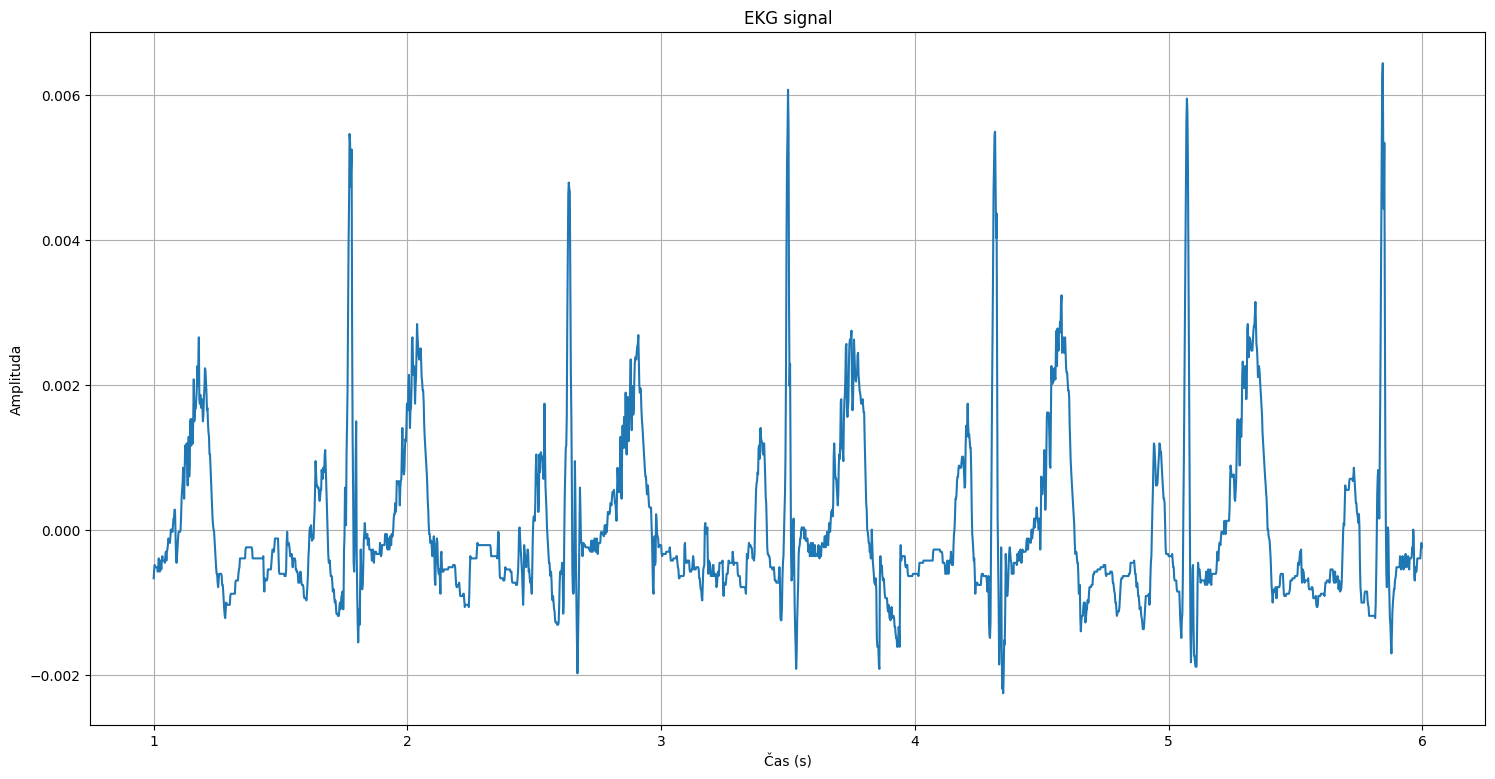

In [163]:
def cut_segment(input, begin, end, fs):
    segment = input[begin * fs : end * fs]
    axis = np.arange(begin, end, 1/fs)
    return axis, segment

axis, segment = cut_segment(x, 1, 6, fs)

# Zobrazení v časové doméně
plt.figure(figsize=(18, 9))
plt.plot(axis, segment)
plt.title('EKG signal')
plt.xlabel('Čas (s)')
plt.ylabel('Amplituda')
plt.grid(True)
plt.show()


b) [1b] Spočítejte spektrum z 5 sekundového úseku nahraného signálu a zobrazte jej.

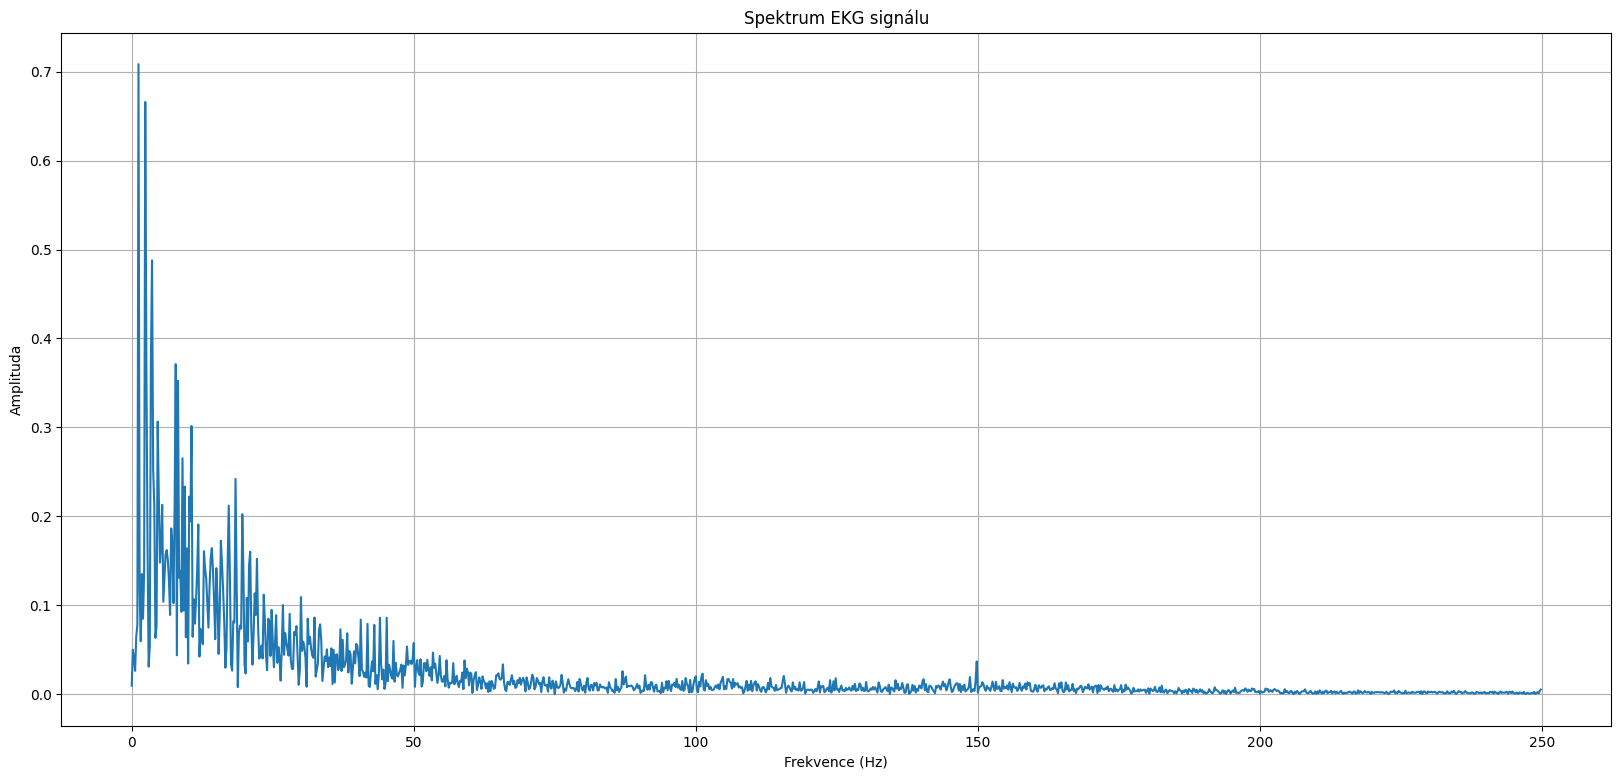

In [164]:
# Spočítání Fourierovy transformace
def do_dft(segment, fs):
    dft = np.abs(np.fft.fft(segment))
    half = dft[:dft.size//2]

    f = np.arange(dft.size//2) * (fs/segment.size)

    f2 = np.fft.fftfreq(segment.size, 1/fs)
    f2_half = f2[:f2.size//2]
    return  f2_half, half

x_frequencies,x_amplitudes = do_dft(segment, fs)

# Zobrazení spektra
plt.figure(figsize=(20, 9))
plt.title('Spektrum EKG signálu')
plt.xlabel('Frekvence (Hz)')
plt.ylabel('Amplituda')
plt.grid(True)
plt.plot(x_frequencies,x_amplitudes)
plt.show()

 c) [0.5b] Ve spektru vidíte rušení na 50Hz nebo 60Hz a jejich harmonických frekvencích. Vysvětlete, čím je způsobeno.

Rušení můžeme pozorovat zejména u frekvence 50 a 150 Hz, jelikož je zmíněno přímo 50/60Hz, odkazuje to nejspíše na rušení elektrické sítě.

### 4.2. [3b] Převzorkujte nahraný signál



a) [2b] Převzorkujte signál na vzorkovací frekvenci 100 Hz, nezapomeňte na filtr pro antialiasing. Můžete například odstranit část spektra od $\frac{Fs}{2}$ nebo použít filtr dolní propusti.

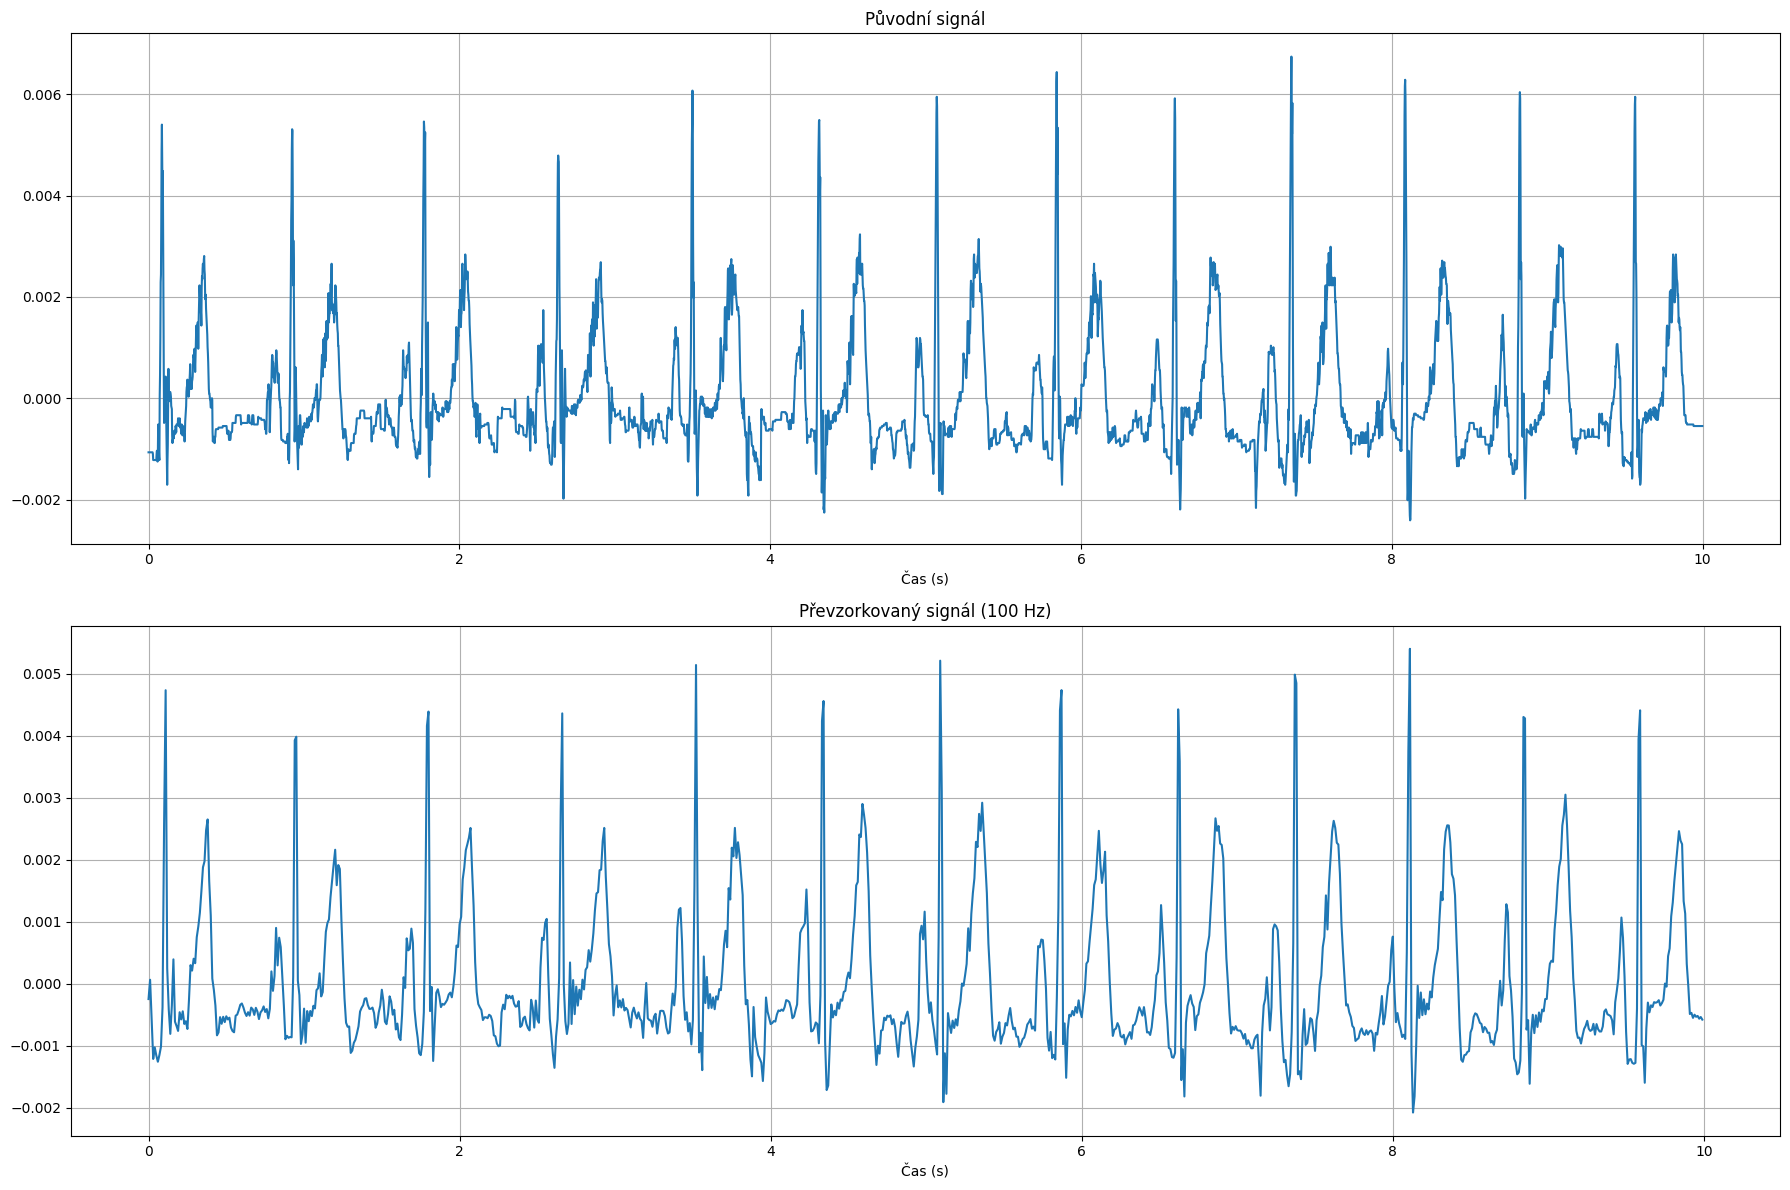

In [171]:
#vstupní signál
time = np.arange(0, x.size/fs, 1/fs)

# Převzorkování na 100 Hz
fs_res = 100

cutoff_freq = fs_res / 2 #Fs/2
#order = 4  # Řád filtru

# Návrh antialiasing filtru
sos = butter(10, cutoff_freq, fs=fs, output="sos")

# Aplikace antialiasing filtru
x_filtered = sosfilt(sos, x)

x_res = resample(x_filtered, int(x.size * fs_res / fs))

# Časová osa pro převzorkovaný signál
t_res = np.arange(0, x_res.size/fs_res, 1/fs_res)

# Zobrazení původního a převzorkovaného signálu
plt.figure(figsize=(18, 12)) #sniž hodnoty pokud jsou grafy příliš velké
plt.subplot(2, 1, 1)
plt.plot(time, x)
plt.title('Původní signál')
plt.xlabel('Čas (s)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_res, x_res)
plt.title('Převzorkovaný signál (100 Hz)')
plt.xlabel('Čas (s)')
plt.grid(True)

plt.tight_layout()
plt.show()

b) [1b] Zobrazte 5 sekundový úsek původního a převzorkovaného signálu v časové doméně a zobrazte i jejich spektra.

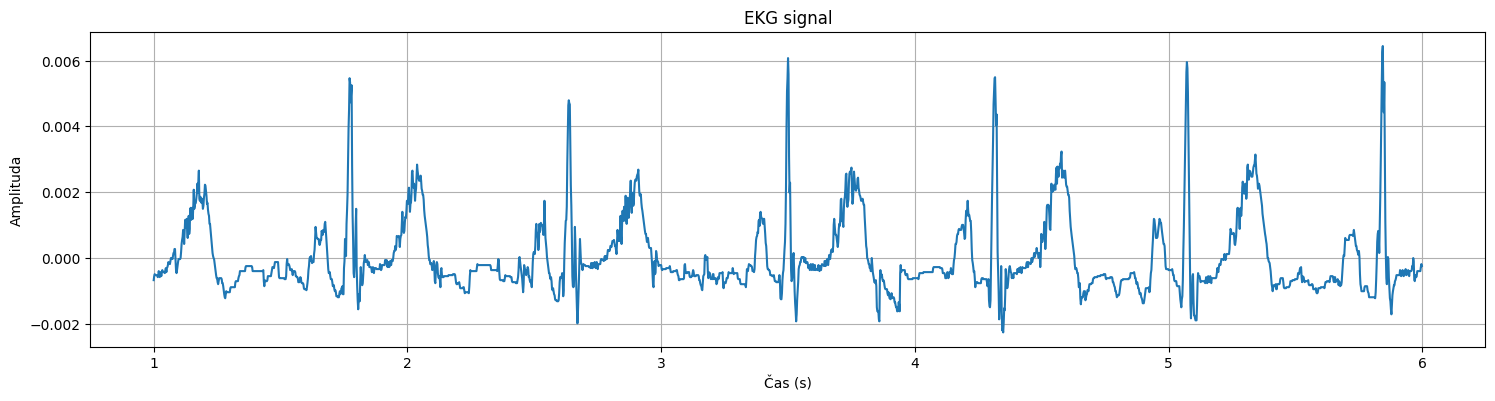

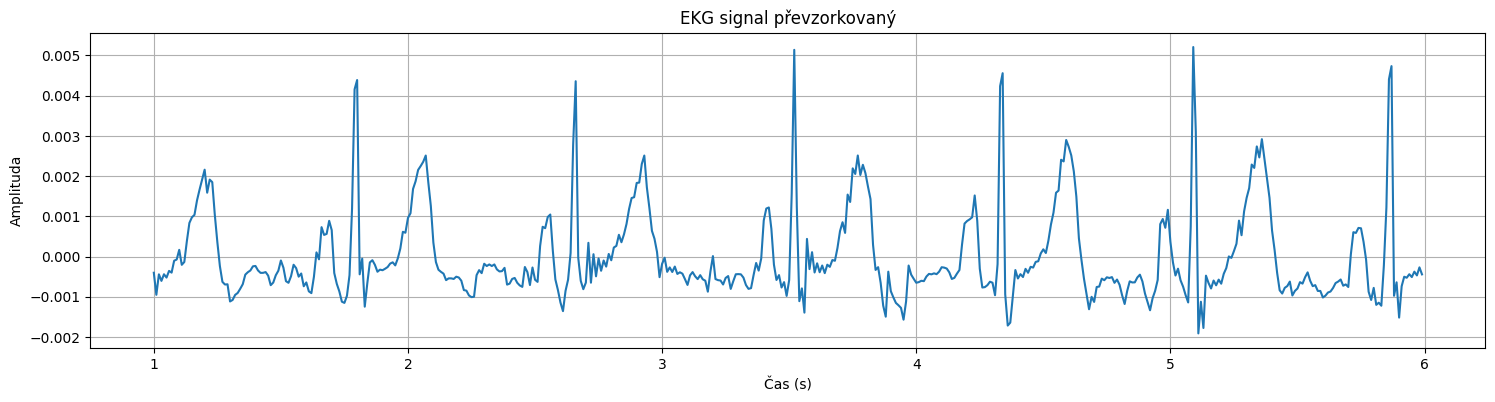

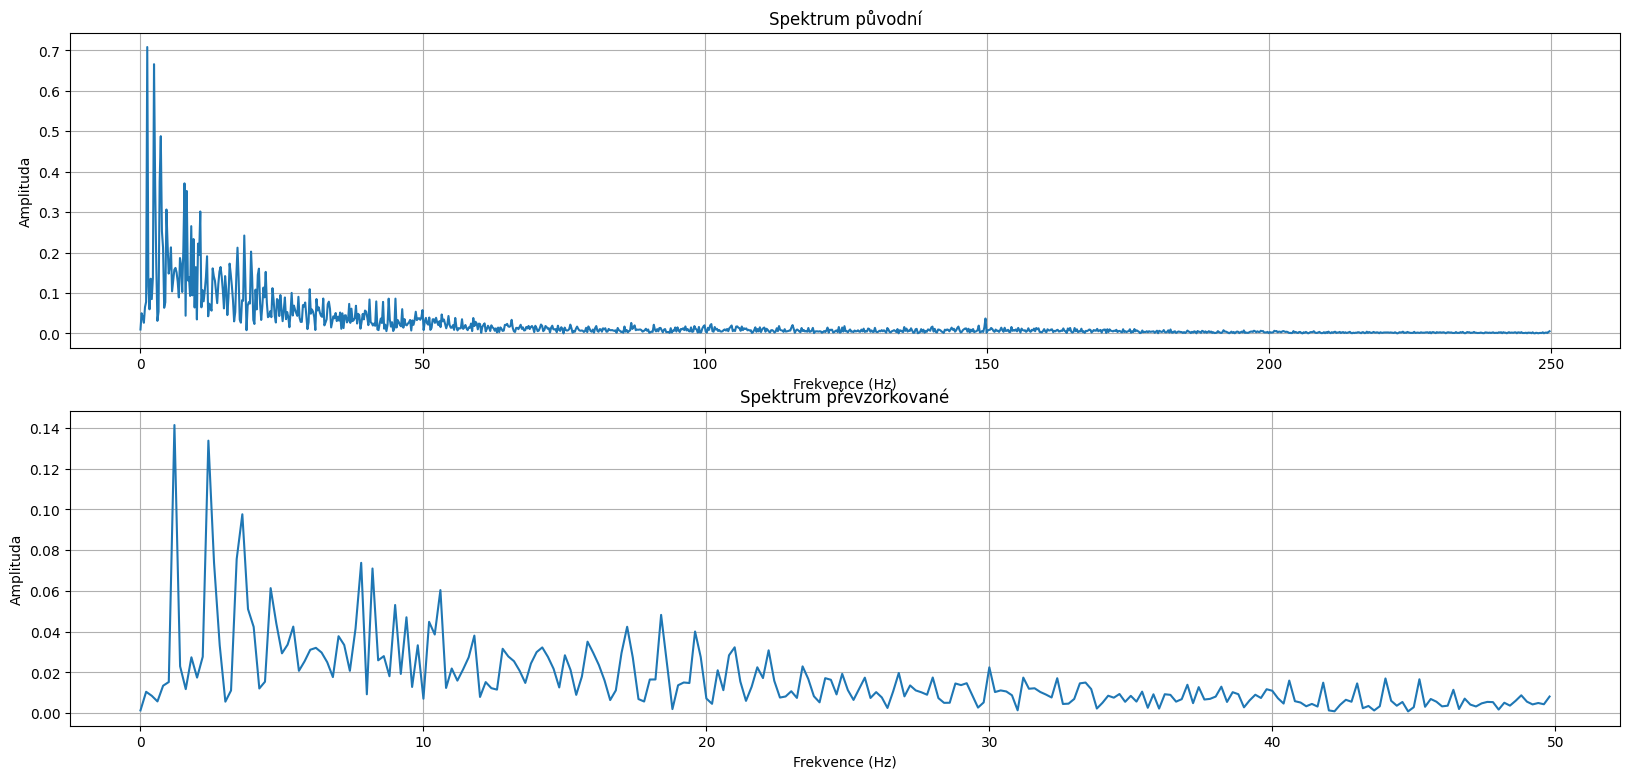

In [167]:
# oříznutí již vytvořených segmentů

#axis, segment = cut_segment(x, 1, 6, fs) # to samé jako 4.1

axis_res, segment_res = cut_segment(x_res, 1, 6, fs_res)

plt.figure(figsize=(18, 9))
plt.subplot(2, 1, 1)
plt.plot(axis, segment)
plt.title('EKG signal')
plt.xlabel('Čas (s)')
plt.ylabel('Amplituda')
plt.grid(True)

plt.figure(figsize=(18, 9))
plt.subplot(2, 1, 1)
plt.plot(axis_res, segment_res)
plt.title('EKG signal převzorkovaný')
plt.xlabel('Čas (s)')
plt.ylabel('Amplituda')
plt.grid(True)
plt.show()

######################################
# DFT z úkolu 4.1
plt.figure(figsize=(20, 9))
plt.subplot(2, 1, 1)
plt.title('Spektrum původní')
plt.xlabel('Frekvence (Hz)')
plt.ylabel('Amplituda')
plt.grid(True)
plt.plot(x_frequencies,x_amplitudes)

x_res_frequencies,x_res_amplitudes = do_dft(segment_res, fs_res)

plt.subplot(2, 1, 2)
plt.title('Spektrum převzorkované')
plt.xlabel('Frekvence (Hz)')
plt.ylabel('Amplituda')
plt.grid(True)
plt.plot(x_res_frequencies,x_res_amplitudes)

plt.show()

### 4.3. [4b] Vyfiltrujte nahraný signál pásmovou propustí 10Hz-20Hz

  




a) [2b] Vytvořte filtr pásmové propusti, možnosti jsou dvě: buďto filtrovat pomocí klasického návrhu filtrů, kde získáte koeficienty `a` a `b` (pomocí např. scipy.butter) a zobrazíte charakteristiku filtru + nuly a póly. Nebo se můžete vydat cestou filtrování ve frekvenční doméně, frekvenční charakteristiku vykreslete pomocí spektrální masky.

  b) [1b] Použijte navržený filtr na nahraný signál. Pokud máte navržený klasický filtr, proveďte filtrování z obou stran, abyste se vyhnuli fázovému posunu, to za vás zajistí například funkce scipy.signal.filtfilt. Vykreslete původní a vyfiltrovaný signál v časové doméně a spočítejte a zobrazte jejich spektra.


In [47]:
# Zde napište váš kód

  c) [1b] Okomentujte rozdíl mezi filtrovaným a nefiltrovaným signálem a jejich spektry. Pokud bychom použili filtrování pouze z jedné strany (obyčejnou konvoluci), jaké je teoreticky největší posunutí ve vzorcích, které se může objevit a proč?




*Zde napište vaše řešení.*

### 4.4. [3b] Vytvořte detektor QRS v časové doméně. Detekované QRS komplexy uložte do vhodné struktury a zároveň zobrazte graf v časové ose se zvýrazněnými QRS detekcemi.

Příklad zakreslené detekce (před odevzdáním smažte):

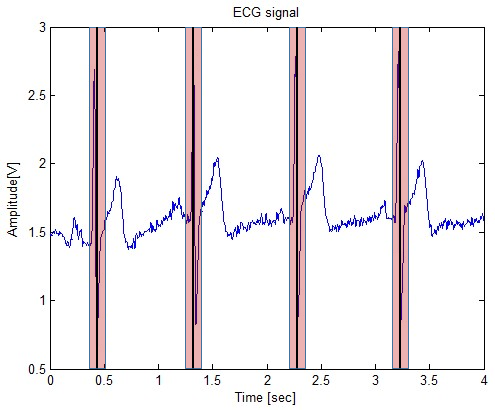

   a) [1b] Detekujte QRS v převzorkovaném vyfiltrovaném signálu pomocí tresholdu (prahu). Pro tuto detekci musíte nejdříve získat vzorek jednoho QRS ze signálu, spočítat si maximální amplitudu a jako treshold vzít vámi určené procento této hodnoty. **Dávejte pozor na možnost otočeného QRS v signálu.** Do vykresleného signálu s detekcemi vykreslete i čáru udávající použitý treshold.

In [48]:
# Zde napište váš kód

b) [2b] Detekujte QRS v signálu pomocí autokorelace v převzorkovaném nefiltrovaném signálu. Pro tuto detekci musíte nejdříve získat vzorek jednoho QRS ze signálu. Dále budete autokorelovat signál právě s tímto výstřižkem. QRS se budou nacházet na místech, kde vám budou vycházet vysoké hodnoty korelace. Do vykresleného signálu s detekcemi zaznačte i vámi zvolený výstřižek.

In [49]:
# Zde napište váš kód

### 4.5. [3.5b] Vytvořte detektor QRS v frekvenční doméně a detekované QRS zakreslete jako v předchozí úloze 4.4

a) [2b] Detekujte QRS pomocí použití spektrogramu. Spočítejte a zobrazte spektrogram nahraného převzorkovaného filtrovaného signálu. Použijte parametry, `hop_size=120ms`a `window_len=200ms`, popřípadě si zkuste s těmito parametry pohrát. Spektrogram dále normalizujte v čase. Spočítejte sumy energie spektra pro jednotlivé časové biny. Dále vytvořte práh podle hodnoty energie spektra u prvního vámi zvoleného QRS komplexu. Tento práh použijte pro detekci zbylých QRS komplexů v signálu.

In [50]:
# Zde napište váš kód

b) [1b] Detekujte QRS pomocí použití obálek a Hilbertovy transformace.

Hilbertova transformace je spočítaná podle následujícího vzorce

$x_a = F^{-1}(F(x) 2U) = x + i y,$

kde F je Fourierova transformace a $F^{-1}$ je její zpětná varianta. $U$ je Heavisideova funkce neboli funkce jednotkového skoku, která je definována: $U(x):$

\begin{cases}
      0.5 & x=0 \\
      1 & 0<x<\frac{N}{2} \text{ pro  $N$  liché} \\
      0.5 & x=\frac{N}{2} \text{ pro  $N$  liché} \\
      1 & 0<x\le\frac{N}{2} \text{ pro  $N$  sudé} \\
      0 & jinak
\end{cases}

kde $N$ je počet koeficientů Fourierovy transformace - pokud není určeno jinak, je to počet vzorků signálu.

Jinými slovy obálku spočítate tak, že:

* Spočítáte FFT $F$ na filtrovaném a převzorkovaném signálu
* Vynulujete pravou symetrickou část spektra
* Levou část spektra vynasobíte 2 kromě prvního a prostředního binu (při sudém počtu frekvenčních binů).
* Provedete zpětnou FFT $F^{-1}$

Abyste získali obálku signálu, je třeba vzít absolutní hodnotu signálu získaného Hilbertovou transformací.

Obálku a signál vykreslete do jednoho grafu přes sebe, obálka by měla obalovat daný signál.

Mělo by to vypadat přibližně takto (před odevzdáním smažte):

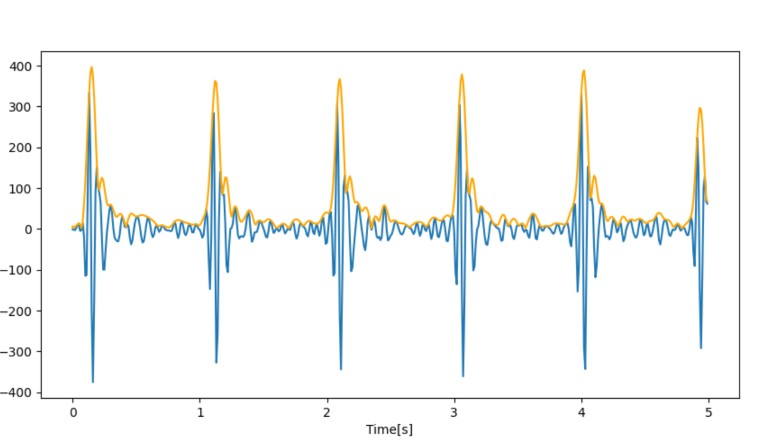

Detekci QRS poté provedete opět prahováním, tentokrát ale obálky signálu.


Při této úloze **nepoužívejte** funkci hilbert z knihovny scipy. Cílem je, abyste si ji napsali sami. Můžete ji použít pouze jako baseline pro porovnání vašich výsledků.



In [51]:
# Zde napište váš kód

c) [0.5b] Při kterých metodách detekcí QRS nám vadí otočený (flipnutý) signál, při kterých ne a proč?

*Zde napište vaše řešení.*

### 4.6 [2b] Detekce R-R intervalu

a)  Detekujte R-R intervaly pomocí detekovaných QRS z jednotlivých metod, které jste použili dříve. Vykreslete hodnoty R-R intervalu do stejného grafu jako EKG signál a detekované QRS. Vykreslení proveďte nad EKG signál, kde osa x bude i nadále časová a každý R-R interval bude zakreslen na x pozici detekovaného QRS. Osa y pro R-R interval bude určovat hodnotu samotného R-R intervalu.

Mělo by to vypadat přibližně takto (před odevzdáním smažte):
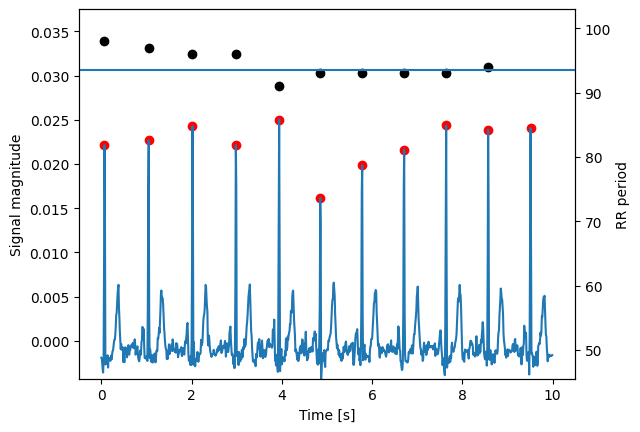

In [52]:
# Zde napište váš kód

### 4.7 Bonus

a) Načtěte si signál obsahující fibrilaci FIS.wav. Proveďte na něm filtrace a převzorkování. Poté zkuste použít nějaký QRS detektor. Z detekovaných QRS detekujte R-R intervaly. Porovnejte R-R intervaly pro fibrilaci a klasický signál bez patologie (sinusovy rytmus). Měli byste vidět prudké změny v R-R intervalech a jejich nepravidelnost. Zároveň se vám může stát, že vám některé metody detekce QRS nepodají tak kvalitní výkon jako při sinusovém rytmu.

In [53]:
# Zde napište váš kód

b) Načtěte si signál obsahující komorovou extrasystolu KES.wav. Proveďte na něm filtrace a převzorkování. Spočítejte a zobrazte spektrogram úseku tohoto signálu. Porovnejte spektrogramy vašeho signálu a signálu KES.wav. Měli byste vidět rozšířenou aktivitu na nízkých frekvencích. Dále zobrazte a porovnejte tyto signály v časové doméně. Obsažené komorové extrasystoly by se měly projevit jako zvláštní široké QRS.

In [54]:
# Zde napište váš kód